In [ ]:
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [ ]:
stock_symbol = 'AAPL' #place the stock symbol


df = pd.read_csv(f'stock_datasets/{stock_symbol}_daily_data.csv')
print(df.head())
print(df.shape)

                        Date      Open      High       Low     Close  \
0  1980-12-12 05:00:00+00:00  0.098834  0.099264  0.098834  0.098834   
1  1980-12-15 05:00:00+00:00  0.094108  0.094108  0.093678  0.093678   
2  1980-12-16 05:00:00+00:00  0.087232  0.087232  0.086802  0.086802   
3  1980-12-17 05:00:00+00:00  0.088951  0.089381  0.088951  0.088951   
4  1980-12-18 05:00:00+00:00  0.091530  0.091959  0.091530  0.091530   

      Volume  Dividends  Stock Splits Symbol  
0  469033600        0.0           0.0   AAPL  
1  175884800        0.0           0.0   AAPL  
2  105728000        0.0           0.0   AAPL  
3   86441600        0.0           0.0   AAPL  
4   73449600        0.0           0.0   AAPL  
(11070, 9)


In [3]:
symbol = df['Symbol'].unique()[0]
print(symbol)

AAPL


In [ ]:
print(df.isna().sum())
df = df.dropna()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Symbol          0
dtype: int64


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
0,1980-12-12 05:00:00+00:00,0.098834,0.099264,0.098834,0.098834,469033600,0.00,0.0,AAPL
1,1980-12-15 05:00:00+00:00,0.094108,0.094108,0.093678,0.093678,175884800,0.00,0.0,AAPL
2,1980-12-16 05:00:00+00:00,0.087232,0.087232,0.086802,0.086802,105728000,0.00,0.0,AAPL
3,1980-12-17 05:00:00+00:00,0.088951,0.089381,0.088951,0.088951,86441600,0.00,0.0,AAPL
4,1980-12-18 05:00:00+00:00,0.091530,0.091959,0.091530,0.091530,73449600,0.00,0.0,AAPL
...,...,...,...,...,...,...,...,...,...
11065,2024-11-04 05:00:00+00:00,220.747138,222.545148,219.468546,221.766006,44944500,0.00,0.0,AAPL
11066,2024-11-05 05:00:00+00:00,221.556241,223.703872,220.896963,223.204422,28111300,0.00,0.0,AAPL
11067,2024-11-06 05:00:00+00:00,222.365355,225.821559,220.946918,222.475235,54561100,0.00,0.0,AAPL
11068,2024-11-07 05:00:00+00:00,224.383137,227.629565,224.323205,227.229996,42137700,0.00,0.0,AAPL


In [5]:

df.drop(columns=['Dividends', 'Stock Splits', 'Symbol'], inplace=True) #these columns won't be needed for forecasts


#for testing purposes let's only consider historical data for the moment
#df = df[['Date', 'Close']]   

df.head()




,Date,Open,High,Low,Close,Volume
0,1980-12-12 05:00:00+00:00,0.098834,0.099264,0.098834,0.098834,469033600
1,1980-12-15 05:00:00+00:00,0.094108,0.094108,0.093678,0.093678,175884800
2,1980-12-16 05:00:00+00:00,0.087232,0.087232,0.086802,0.086802,105728000
3,1980-12-17 05:00:00+00:00,0.088951,0.089381,0.088951,0.088951,86441600
4,1980-12-18 05:00:00+00:00,0.091530,0.091959,0.091530,0.091530,73449600


In [6]:
#change date

df['Date'] = pd.to_datetime(df['Date']).dt.date
df['Date'] = pd.to_datetime(df['Date'])
print(df['Date'])
df.set_index('Date', inplace=True )
df.head()


0       1980-12-12
1       1980-12-15
2       1980-12-16
3       1980-12-17
4       1980-12-18
           ...    
11065   2024-11-04
11066   2024-11-05
11067   2024-11-06
11068   2024-11-07
11069   2024-11-08
Name: Date, Length: 11070, dtype: datetime64[ns]


,Open,High,Low,Close,Volume
Date,,,,,
1980-12-12,0.098834,0.099264,0.098834,0.098834,469033600
1980-12-15,0.094108,0.094108,0.093678,0.093678,175884800
1980-12-16,0.087232,0.087232,0.086802,0.086802,105728000
1980-12-17,0.088951,0.089381,0.088951,0.088951,86441600
1980-12-18,0.091530,0.091959,0.091530,0.091530,73449600


In [7]:
fig = px.line(df, x=df.index, y=df['Close'], title=f'Stock prices over time for stock {symbol}')
fig.show()

# Forecasting

In [8]:
#while we're still creating the lstm model, let's use a subset of our dataset



#df_testing = df.loc['2000-01-01':]
df_testing = df
df_testing.shape

(11070, 5)

In [9]:
#train/test split

n = len(df_testing)
training_data = df_testing[0:int(n*0.7)]
validation_data = df_testing[int(n*0.7):int(n*0.9)]
test_data = df_testing[int(n*0.9):]



In [10]:
def df_to_X_Y(df, window_size=8):
    df_as_np = df.to_numpy()
    X = []
    Y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][3]
        Y.append(label)
    return np.array(X), np.array(Y)

In [11]:
#df_testing = df_testing[['Close']]
X, Y = df_to_X_Y(df_testing)
X.shape, Y.shape

((11062, 8, 5), (11062,))

In [12]:
n = len(df_testing)
threshold = 0.9

X_train, Y_train = X[:int(n*threshold)], Y[:int(n*threshold)]
X_test, Y_test = X[int(n*threshold):], Y[int(n*threshold):]



In [13]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape


((9963, 8, 5), (9963,), (1099, 8, 5), (1099,))

In [14]:
# Initialize scalers
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
Y_train_scaled = scaler_Y.fit_transform(Y_train.reshape(-1, 1))



X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
Y_test_scaled = scaler_Y.transform(Y_test.reshape(-1, 1))

In [15]:
# Build the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    LSTM(100, return_sequences=False),
    Dense(50, activation='relu'),  # Add a Dense layer for complexity
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Train the model
history = model.fit(
    X_train_scaled, Y_train_scaled,
    epochs=40,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

c:\Users\João\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0041
Epoch 2/40
  9/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 2.6423e-05

c:\Users\João\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 6.7226e-05
Epoch 3/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 7.4528e-05
Epoch 4/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 6.5447e-05
Epoch 5/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 6.9690e-05
Epoch 6/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.5283e-05
Epoch 7/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 6.6838e-05
Epoch 8/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4757e-05
Epoch 9/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.9038e-05
Epoch 10/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.7275e-05
Epoch 11/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.2149e-05
Epoch 12/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.5553e-05
Epoch 13/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.3111e-05
Epoch 14/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 3.6281e-05
Epoch 15/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 4.3804e-

In [16]:
# Predict on the test set
Y_test_pred_scaled = model.predict(X_test_scaled)

# Inverse transform predictions and actual values to the original scale
Y_test_pred = scaler_Y.inverse_transform(Y_test_pred_scaled)
Y_test_original = scaler_Y.inverse_transform(Y_test_scaled)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(Y_test_original, Y_test_pred))
mae = mean_absolute_error(Y_test_original, Y_test_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


RMSE: 8.526659109648321
MAE: 6.810946914908884


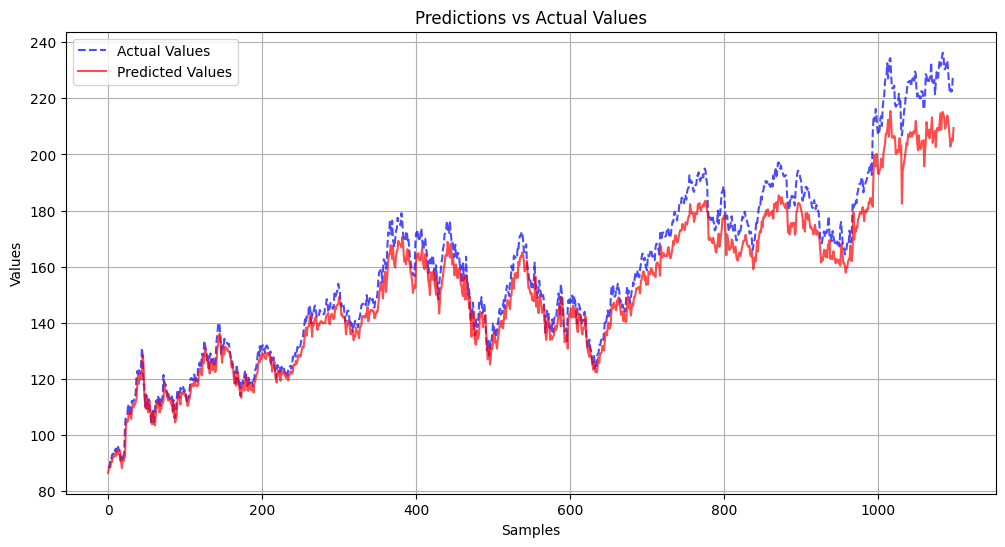

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(Y_test_original, label="Actual Values", linestyle='--', color='blue', alpha=0.7)
plt.plot(Y_test_pred, label="Predicted Values", color='red', alpha=0.7)
plt.title(f"Predictions vs Actual Values for stock {stock_symbol}")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()

# Future predictions


Epoch 1/40


c:\Users\João\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



346/346 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0055
Epoch 2/40
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.0188e-04
Epoch 3/40
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 7.5533e-05
Epoch 4/40
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 6.5905e-05
Epoch 5/40
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 7.9305e-05
Epoch 6/40
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 7.7107e-05
Epoch 7/40
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 6.7354e-05
Epoch 8/40
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.4957e-05
Epoch 9/40
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 6.3373e-05
Epoch 10/40
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 6.5244e-05
Epoch 11/40
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 5.2942e-05
Epoch 12/40
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.7287e-05
Epoch 13/40
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 5.6488e-05
Epoch 14/40
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.3804e-05
Ep

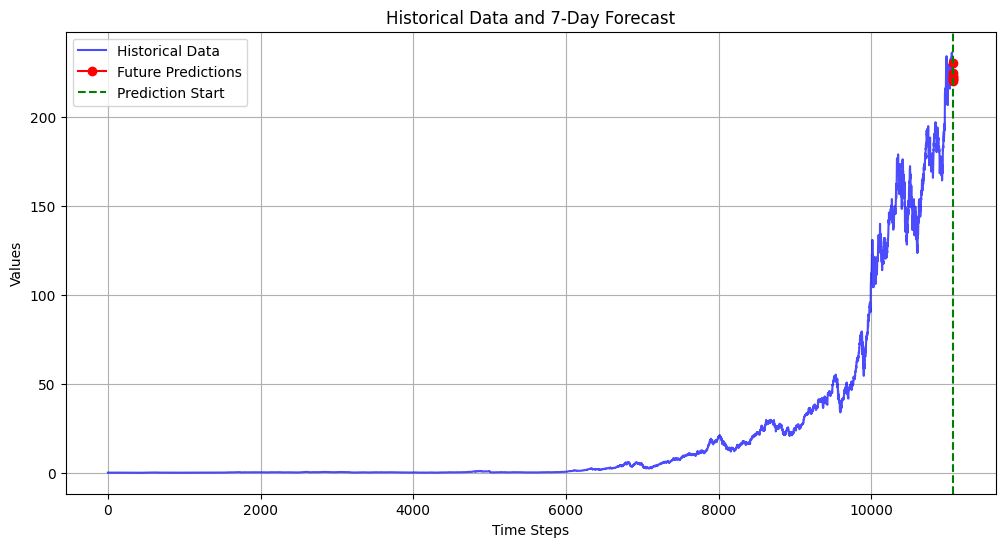

In [ ]:
# Use the entire dataset for training
X_full, Y_full = df_to_X_Y(df_testing)

# Scale the entire dataset
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_full_scaled = scaler_X.fit_transform(X_full.reshape(-1, X_full.shape[2])).reshape(X_full.shape)
Y_full_scaled = scaler_Y.fit_transform(Y_full.reshape(-1, 1))

# Train the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_full_scaled.shape[1], X_full_scaled.shape[2])),
    LSTM(100, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Train using the full dataset
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = model.fit(X_full_scaled, Y_full_scaled, epochs=40, batch_size=32, callbacks=[early_stopping], verbose=1)

# Predict 7 days into the future
last_window = X_full_scaled[-1]  # Last window for starting the prediction
future_predictions_scaled = []

for _ in range(7):  # Predict for 7 days
    last_window_batch = np.expand_dims(last_window, axis=0)  # Add batch dimension
    next_prediction_scaled = model.predict(last_window_batch)[0][0]
    future_predictions_scaled.append(next_prediction_scaled)
    next_row = last_window[-1].copy()  # Copy the last row
    next_row[-1] = next_prediction_scaled  # Update with the predicted value
    last_window = np.vstack([last_window[1:], next_row])  # Slide the window

# Inverse transform the predictions
future_predictions = scaler_Y.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# Combine historical data and future predictions
historical_data = df_testing['Close'].values  # Original 'Close' column
future_time_steps = range(len(historical_data), len(historical_data) + 7)  # Future time indices

# Plot historical data and future predictions
plt.figure(figsize=(12, 6))
plt.plot(historical_data, label='Historical Data', color='blue', alpha=0.7)
plt.plot(future_time_steps, future_predictions, label='Future Predictions', color='red', marker='o')
plt.axvline(x=len(historical_data)-1, color='green', linestyle='--', label='Prediction Start')
plt.title(f"Historical Data and 7-Day Forecast for stock{stock_symbol}")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()


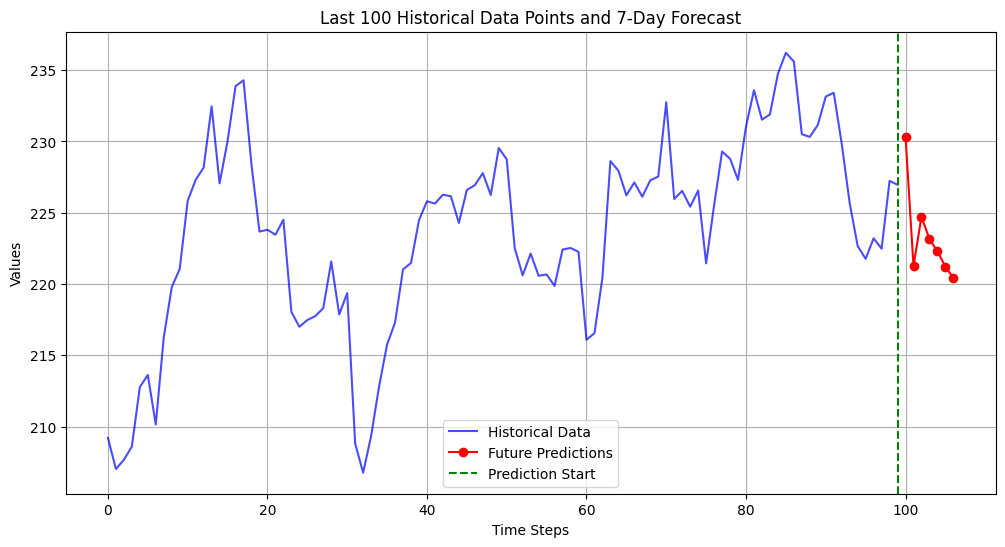

In [ ]:
# Plot the last 100 historical data points and future predictions
plt.figure(figsize=(12, 6))
plt.plot(range(len(historical_data[-100:])), historical_data[-100:], label='Historical Data', color='blue', alpha=0.7)
adjusted_future_time_steps = range(len(historical_data[-100:]), len(historical_data[-100:]) + len(future_time_steps))
plt.plot(adjusted_future_time_steps, future_predictions, label='Future Predictions', color='red', marker='o')
plt.axvline(x=len(historical_data[-100:]) - 1, color='green', linestyle='--', label='Prediction Start')
plt.title("Last 100 Historical Data Points and 7-Day Forecast")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.grid()

# Show the plot
plt.show()
